In [1]:
import geopandas as gpd
import pandas as pd
import os
import yaml
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from shapely.geometry import Point
from pyproj import Transformer
import pystac_client
from pystac_client.stac_api_io import StacApiIO
import planetary_computer
import leafmap
import leafmap.colormaps
from shapely import wkt

In [116]:
config_path = '/home/benchuser/code/config.yml'
with open(config_path, "r") as file:
    config = yaml.safe_load(file)
        
version = config['dataset']['version']
# version = 'v0.40.2'
working_dir = Path(config['directory']['working'])
output_dir = Path(config['directory']['output'])
aoi_version = config['aoi']['version']

print(yaml.dump(config))

aoi:
  exclude_indices: null
  include_indices: null
  version: v0.30
chips:
  chip_size: 960
  sample_size: 960
dataset:
  version: v0.40.7
dem:
  collection: cop-dem-glo-30
  dtype: float32
  fill_na: false
  na_value: -999
  native_crs: false
  resolution: 30
  year: 2021-01-02/2021-12-31
directory:
  output: /home/benchuser/final_data
  working: /home/benchuser/data
land_cover:
  collection: io-lulc-annual-v02
  dtype: int8
  fill_na: false
  na_value: 0
  native_crs: false
  resolution: 10
  sampling_factor: null
  year: 2023-01-02/2023-12-31
landsat:
  bands:
  - coastal
  - blue
  - green
  - red
  - nir08
  - swir16
  - swir22
  - qa_pixel
  cloud_band: qa_pixel
  cloud_cover: 100
  collection: landsat-c2-l2
  delta_days: 91
  dtype: float32
  fill_na: false
  na_value: -999
  native_crs: false
  platforms:
  - landsat-8
  - landsat-9
  resolution: 30
log_errors: true
sentinel_1:
  bands:
  - vv
  - vh
  collection: sentinel-1-rtc
  delta_days: 12
  dtype: float32
  fill_na: fa

In [3]:
metadata_filepath = Path(working_dir / version / 'chip_metadata.csv')

In [4]:
chip_df = pd.read_csv(metadata_filepath)

In [5]:
aoi_gdf = gpd.read_file(Path(working_dir) / version / 'aoi_metadata.geojson')
aoi_gdf['centroid'] = aoi_gdf.centroid
aoi_gdf.geometry = aoi_gdf['centroid']
print(Path(working_dir) / version / 'aoi_metadata.geojson')

/home/benchuser/data/v0.40.7/aoi_metadata.geojson


ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/envs/gfm_bench/share/proj failed


In [6]:
aoi_gdf

,status,geometry,centroid
0,Internal Server Error,"POLYGON ((21.64939 3.53375, 21.64939 3.45467, ...",POINT (21.69238 3.49421)
1,Internal Server Error,"POLYGON ((18.96891 5.4779, 18.96891 5.44708, 1...",POINT (18.98749 5.46249)
2,s2 scenes missing,"POLYGON ((8.28178 7.2393, 8.28178 7.211, 8.304...",POINT (8.29336 7.22515)
3,s1 scenes missing,"POLYGON ((-2.53479 15.81157, -2.53479 15.42575...",POINT (-2.33595 15.61866)
4,success,"POLYGON ((38.53933 9.3094, 38.53933 8.72942, 3...",POINT (38.80049 9.01941)
...,...,...,...
407,landsat scenes missing,"POLYGON ((-73.62022 45.57931, -73.62022 45.541...",POINT (-73.59011 45.5604)
408,landsat scenes missing,"POLYGON ((-52.73406 47.56979, -52.73406 47.550...",POINT (-52.71739 47.56037)
409,landsat scenes missing,"POLYGON ((-75.20969 20.14866, -75.20969 20.146...",POINT (-75.20858 20.14756)
410,landsat scenes missing,"POLYGON ((-79.96607 22.40669, -79.96607 22.402...",POINT (-79.96356 22.40449)


In [7]:
aoi_gdf['aoi_index'] = aoi_gdf.index

In [8]:
aoi_gdf['status'] = aoi_gdf['status'].map(lambda x: 'other error' if len(x) > 40 else x)

In [9]:
unique_statuses = list(aoi_gdf['status'].unique())
colors = leafmap.colormaps.get_palette('tab20', n_class=len(unique_statuses))
cmap = {status: f'#{color}' for status, color in zip(unique_statuses, colors)}
cmap['success'] = '#66FF00'
aoi_gdf['color'] = aoi_gdf['status'].map(lambda x: cmap[x])

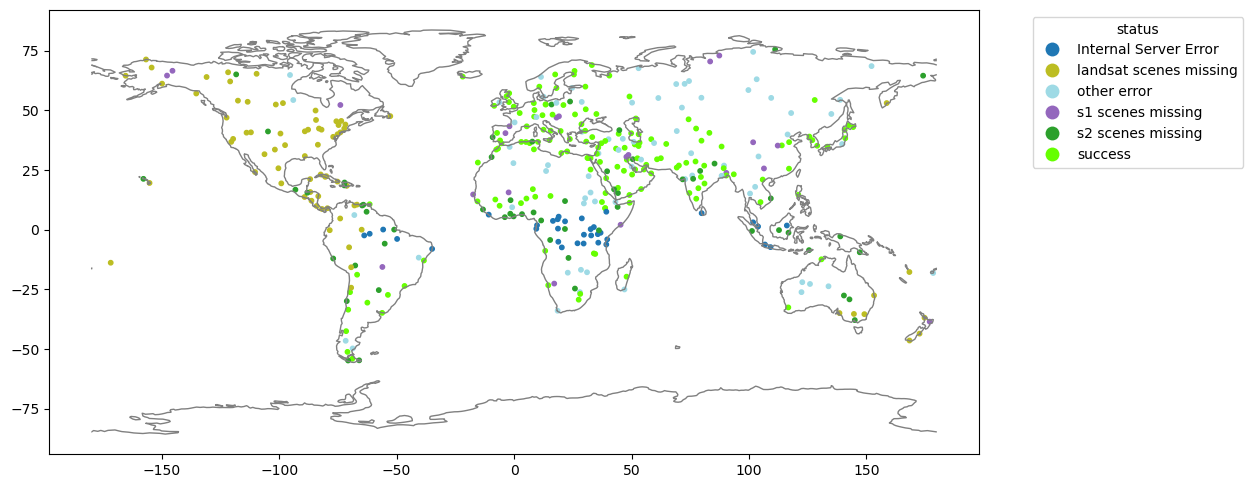

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))
coastline = gpd.read_file('https://raw.githubusercontent.com/martynafford/natural-earth-geojson/refs/heads/master/110m/physical/ne_110m_coastline.json')
coastline.plot(color='grey', linewidth = 1, ax=ax)

aoi_gdf['status'] = aoi_gdf['status'].astype('category')
ordered_colors = [cmap[k] for k in aoi_gdf['status'].cat.categories]
cmap = ListedColormap(ordered_colors)

aoi_gdf.plot(
    'status', 
    cmap=cmap, 
    ax=ax, 
    markersize=10, 
    legend=True, 
    legend_kwds={'bbox_to_anchor': (1.05, 1), 'loc': 'upper left', 'title': 'status'}
)
# Show the plot
plt.show()

In [11]:
aoi_gdf.explore('status', cmap=cmap, marker_kwds={'radius':4})

<Axes: xlabel='status'>

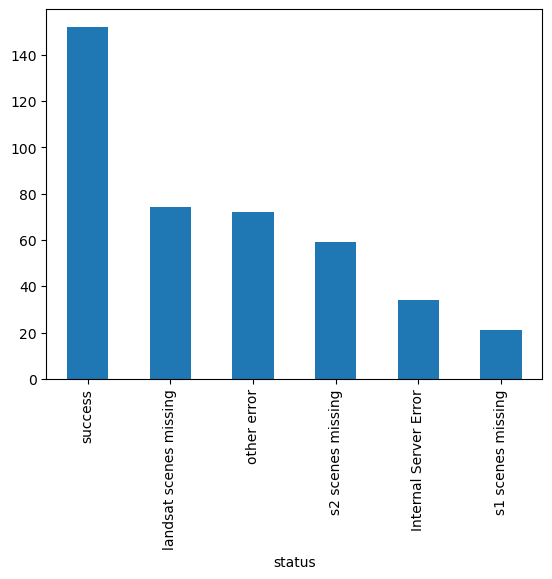

In [12]:
aoi_gdf['status'].value_counts().plot.bar()

In [13]:
len(aoi_gdf[aoi_gdf['status'] == 'success']) / len(aoi_gdf)

0.36893203883495146

In [14]:
pd.crosstab(chip_df['land_cover'], chip_df['status'], margins=True)

status,dem missing values,land_cover_11_limit,land_cover_1_limit,land_cover_2_limit,land_cover_5_limit,land_cover_7_limit,land_cover_8_limit,landsat missing values,sentinel_1 missing values,sentinel_2 missing values,success,All
land_cover,,,,,,,,,,,,
1.0,45700,0,13461,0,0,0,0,52470,33,1267,4700,117631
2.0,0,0,0,8336,0,0,0,25317,74,1230,4994,39951
5.0,7,0,0,0,11948,0,0,22805,479,1866,14258,51363
7.0,0,0,0,0,0,117,0,7488,68,263,2696,10632
8.0,29,0,0,0,0,0,47903,4146,64,1203,6802,60147
11.0,5,124705,0,0,0,0,0,42837,656,3004,22952,194159
All,45741,124705,13461,8336,11948,117,47903,155063,1374,8833,56402,473883


In [15]:
chip_df['chip_footprint_4326'] = gpd.GeoSeries(chip_df['chip_footprint'].dropna().map(wkt.loads), crs=4326)

In [16]:
chip_df = gpd.GeoDataFrame(chip_df, geometry = 'chip_footprint_4326', crs=4326)
chip_df['land cover and error'] = chip_df['land_cover'].astype(str) + '_' + chip_df['status']

In [22]:
aoi = 196

In [23]:
chip_df[chip_df['aoi_index'] == aoi].explore('land cover and error', tiles="http://mt0.google.com/vt/lyrs=s&hl=en&x={x}&y={y}&z={z}", attr="Google", marker_kwds=dict(radius=5))


In [24]:
land_cover_cmap = {
    "1": "#419bdf",  # Water
    "2": "#397d49",  # Trees
    "4": "#7a87c6",  # Flooded Vegetation
    "5": "#e49635",  # Crops
    "7": "#c4281b",  # Built Area
    "8": "#a59b8f",  # Bare Ground
    "9": "#a8ebff",  # Snow/Ice
    "10": "#616161",  # Clouds
    "11": "#e3e2c3"   # Rangeland
}

border_color_dict = {
    'success': '#66FF00',
    'landsat missing values': '#FFFFFF',
}

In [25]:
def get_color_from_status(land_cover: float):
    land_cover_string = str(land_cover).split('.')[0]
    hex_color = land_cover_cmap.get(land_cover_string, '#000000')
    return hex_color
def get_border_from_status(status: str):
    border_color = border_color_dict.get(status, '#000000')
    return border_color

In [26]:
callback = lambda feat: {
    "color": feat['properties']['border_color'],
    "weight": 2,
    "fillColor": feat['properties']['color'],
    "fillOpacity": 1
}
m = leafmap.Map()
aoi_chips = chip_df[chip_df['aoi_index'] == aoi]
aoi_chips['color']=aoi_chips['land_cover'].apply(lambda x: get_color_from_status(x))
aoi_chips['border_color']=aoi_chips['status'].apply(lambda x: get_border_from_status(x))
m.add_gdf(
    aoi_chips,
    style_callback=callback,
    layer_name=f"Chip Footprints (AOI {aoi})",
    zoom_to_layer=True,
)

In [27]:
stac_items = gpd.read_file(Path(working_dir) / version / f"{aoi}_stac_items.json")

Skipping field instruments: unsupported OGR type: 5
Skipping field s1:shape: unsupported OGR type: 1
Skipping field proj:bbox: unsupported OGR type: 3
Skipping field proj:shape: unsupported OGR type: 1
Skipping field proj:transform: unsupported OGR type: 3
Skipping field sar:polarizations: unsupported OGR type: 5


In [28]:
# initialize pystac client with retry policy
stac_api_io = StacApiIO()
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
    stac_io=stac_api_io
)

In [29]:
supercell_ids = list(stac_items['supercell'].dropna().unique())
search = catalog.search(
    collections='io-lulc-annual-v02',
    datetime = '2023-01-02/2023-12-31',
    query = {
        'supercell' : {'in': supercell_ids}
    }
)
items = search.item_collection()

In [30]:
for item in items:
    url = item.assets['data'].href
    m.add_cog_layer(url, colormap = land_cover_cmap, zoom_to_layer=False)

In [31]:
m

Map(center=[35.51106528885646, 129.31296460120456], controls=(ZoomControl(options=['position', 'zoom_in_text',…

## Move a Sample of Chips

In [136]:
def get_first_n_chips(n, chip_df):
    success_chips = chip_df[chip_df['status'] == 'success']
    success

In [137]:
success_chips = chip_df[chip_df['status'] == 'success']

In [138]:
success_sample = success_chips.head(50)

In [139]:
chip_indices = [str(index).zfill(6) for index in success_sample.chip_index]

In [140]:
working_dir / version

PosixPath('/home/benchuser/data/v0.40.7')

In [143]:
def find_chip_files(indices: list[str], data_dir: Path) -> list[Path]:

    indices_set = set(indices)
    matching_files = []
    
    all_chip_files = data_dir.glob('*_*.*')

    for file_path in all_chip_files:
        if 'sentinel' in file_path.stem:
            chip_id = file_path.stem.split('_')[2]
        else:
            chip_id = file_path.stem.split('_')[1]
        if chip_id in indices_set:
            matching_files.append(file_path)
            
    return matching_files


In [144]:
sample_file_paths = find_chip_files(chip_indices, (working_dir / version))

In [ ]:
sample_file_paths

In [146]:
dest_directory = working_dir / f'sample_chips_{version}'
dest_directory.mkdir(exist_ok=True)

In [147]:
import shutil
for sample_file_paths in sample_file_paths:
    shutil.copy(sample_file_paths, dest_directory)

In [148]:
success_sample = success_sample.drop('land cover and error', axis=1)

In [149]:
success_sample['land_cover'] = success_sample['land_cover'].map(lambda x: int(x))

In [150]:
success_sample['x_center'] = success_sample.geometry.centroid.x
success_sample['y_center'] = success_sample.geometry.centroid.y

In [151]:
import random
success_sample['cls_dim1'] = np.random.uniform(-180, 180, size=len(success_sample))
success_sample['cls_dim2'] = np.random.uniform(-180, 180, size=len(success_sample))

In [152]:
success_sample['centroid'] = success_sample.geometry.centroid
success_sample.geometry = success_sample.centroid

In [153]:
success_sample = success_sample.set_geometry('centroid')

In [154]:
success_sample = success_sample.drop('chip_footprint_4326', axis=1)

In [155]:
success_sample = success_sample.rename({'epsg': 'chip_epsg'})

In [156]:
success_sample.to_file(working_dir / f'sample_chips_{version}' / 'chip_metadata.json', driver='GeoJSON')

In [157]:
success_sample.to_csv(working_dir / f'sample_chips_{version}' / 'chip_metadata.csv')

In [158]:
import shutil
output_zip_file = working_dir / f'sample_chips_{version}'
shutil.make_archive(output_zip_file, 'zip', dest_directory)

'/home/benchuser/data/sample_chips_v0.40.7.zip'

In [159]:
shutil.rmtree(Path('/home/benchuser/code/data') / f'sample_chips_{version}')

In [160]:
shutil.copytree((working_dir / f'sample_chips_{version}'), Path('/home/benchuser/code/data') / f'sample_chips_{version}')

PosixPath('/home/benchuser/code/data/sample_chips_v0.40.7')